In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_context('notebook')
import json
%matplotlib inline
import requests
import warnings
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")

# Scraping

#### We will start by using postman to spy on the get requests that are sent for both website, in order to retrieve the url that loads the rankings in the corresponding websites. To do this, we send requests to both websites and retrieve the information as json files and extract two dictionarries that will be used to form the dataframes

In [2]:
r_THE = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
r_QS = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508593854921')

data_THE = r_THE.json() #ranking data for timeshighereducation.com
data_QS = r_QS.json()  #ranking data for topuniversities.com

##### We only took the data part for each json, which is of interest

In [3]:
print(list(data_THE.keys()))
print(list(data_QS.keys()))

['data', 'subjects', 'locations', 'pillars']
['data']


In [4]:
df_rank_THE = pd.DataFrame(data_THE['data'])
df_rank_QS = pd.DataFrame(data_QS['data'])

##### We create the two dataframes and drop all the universites ranked above 200

In [5]:
# We need to clean the rankings in replacing first special characters

df_rank_THE['rank'] = df_rank_THE['rank'].replace("=|–|\+", "", regex=True).astype(int)
df_rank_THE = df_rank_THE.drop(df_rank_THE[df_rank_THE['rank'] > 200].index)

df_rank_QS['rank_display'] = df_rank_QS['rank_display'].replace("=|-|\+", "", regex=True).astype(int)
df_rank_QS = df_rank_QS.drop(df_rank_QS[df_rank_QS['rank_display'] > 200].index)

##### Then, we select the required features for both dataframes

In [6]:
THE_features = ['name', 'location', 'rank', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']
df_rank_THE = df_rank_THE[THE_features]

df_rank_THE = df_rank_THE.set_index('name').sort_index(ascending=True)
df_rank_THE.index.name = 'University'


In [7]:
QS_features = ['country', 'region', 'rank_display']

df_rank_QS = df_rank_QS.set_index('title').sort_index(ascending=True)

urls = df_rank_QS['url'] # We need to search further informations as the list isn't exhaustive, hence the url we are saving 
df_rank_QS = df_rank_QS[QS_features]

# Question 1
For this question, we will obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018]
In particular, we will extract the following fields for each university: **name**, **rank**, **country** and **region**, **number of faculty members (international and total)** and **number of students (international and total)**.
Then, store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

##### For the first webpage, we need to scrap more data from the detail page of each university. Postman was very helpful for finding tags with the corresponing informations.

In [8]:
link = 'https://www.topuniversities.com/'
university = {'title': [],
              'faculty members total': [],
              'faculty members international': [],
              'students total': [],
              'students international': []}

for uni in tqdm([u for u in urls.iteritems()]):
    soup = BeautifulSoup(requests.get(link + uni[1]).text, 'html.parser')
    
    faculty = soup.find('div', class_='faculty-main wrapper col-md-4 item active')
    if faculty is not None:
        faculty = faculty.find_all('div', class_='number')
        
    students = soup.find('div', class_='students-main wrapper col-md-4 item')
    if students is not None:
        students = students.find('div', class_='number')
    
    int_students = soup.find('div', class_='int-students-main wrapper col-md-4 item')
    if int_students is not None:
        int_students = int_students.find('div', class_='number')
    
    
    if faculty is not None:
        if len(faculty) > 1:
            university['faculty members total'].append(int(faculty[0].text.replace(',', '')))
            university['faculty members international'].append(int(faculty[1].text.replace(',', '')))
        else:
            university['faculty members total'].append(int(faculty[0].text.replace(',', '')))
            university['faculty members international'].append(None)
    else:
        university['faculty members total'].append(None)
        university['faculty members international'].append(None)
        
        
    if students is not None:
        university['students total'].append(int(students.text.replace(',', '')))
        
    else:
        university['students total'].append(None)
    
    if int_students is not None:
        university['students international'].append(int(int_students.text.replace(',', '')))
        
    else:
        university['students international'].append(None)

    university['title'].append(uni[0])
        

##### We join the original dataframe with the additional informations collected and rearrange headers in a intuitive way

In [9]:
df_rank_QS_supp = pd.DataFrame(university).set_index('title')
df_rank_QS = df_rank_QS.join(df_rank_QS_supp)
df_rank_QS.head()

,country,region,rank_display,faculty members international,faculty members total,students international,students total
title,,,,,,,
Aalto University,Finland,Europe,137,370.0,1257.0,1831.0,12147.0
Aarhus University,Denmark,Europe,119,602.0,2316.0,3762.0,26226.0
Albert-Ludwigs-Universitaet Freiburg,Germany,Europe,171,413.0,1966.0,3897.0,23214.0
Alma Mater Studiorum - University of Bologna,Italy,Europe,188,153.0,2990.0,4195.0,63399.0
Boston University,United States,North America,81,379.0,3157.0,7041.0,25662.0


In [10]:
col = [('', 'Country'), ('', 'Region'), ('', 'Rank'), ('Faculty members', 'international'), ('Faculty members', 'total'), ('Students', 'international'), ('Students', 'total')]
df_rank_QS.columns = pd.MultiIndex.from_tuples(col)
df_rank_QS.index.name = 'University'

## University

In [11]:
QS_ratio_university = df_rank_QS.copy()

QS_ratio_university['Ratio', 'faculty/students'] = QS_ratio_university['Faculty members', 'total'] / QS_ratio_university['Students', 'total']
QS_ratio_university['Ratio', 'international/total'] = QS_ratio_university['Students', 'international'] / QS_ratio_university['Students', 'total']

### Best faculty/students ratio
According to our plot below, we can see that the best university in term of ratio faculty members and students is : Caltech

In [12]:
QS_ratio_university = QS_ratio_university.sort_values(('Ratio', 'faculty/students'), ascending=False)

In [13]:
def plot_ratio(dataframe, ratio, title):
    fig, axe = plt.subplots(figsize=(20, 10))
    plt.title('Proportion of '+ str(title), fontsize=30)
    plt.xticks(rotation=90, fontsize=20 )

    sns.barplot( x=dataframe.index[:20], y=dataframe['Ratio', ratio][:20])
    axe.set_ylabel('Ratio ' + str(ratio), fontsize=20)
    axe.set_xlabel('')

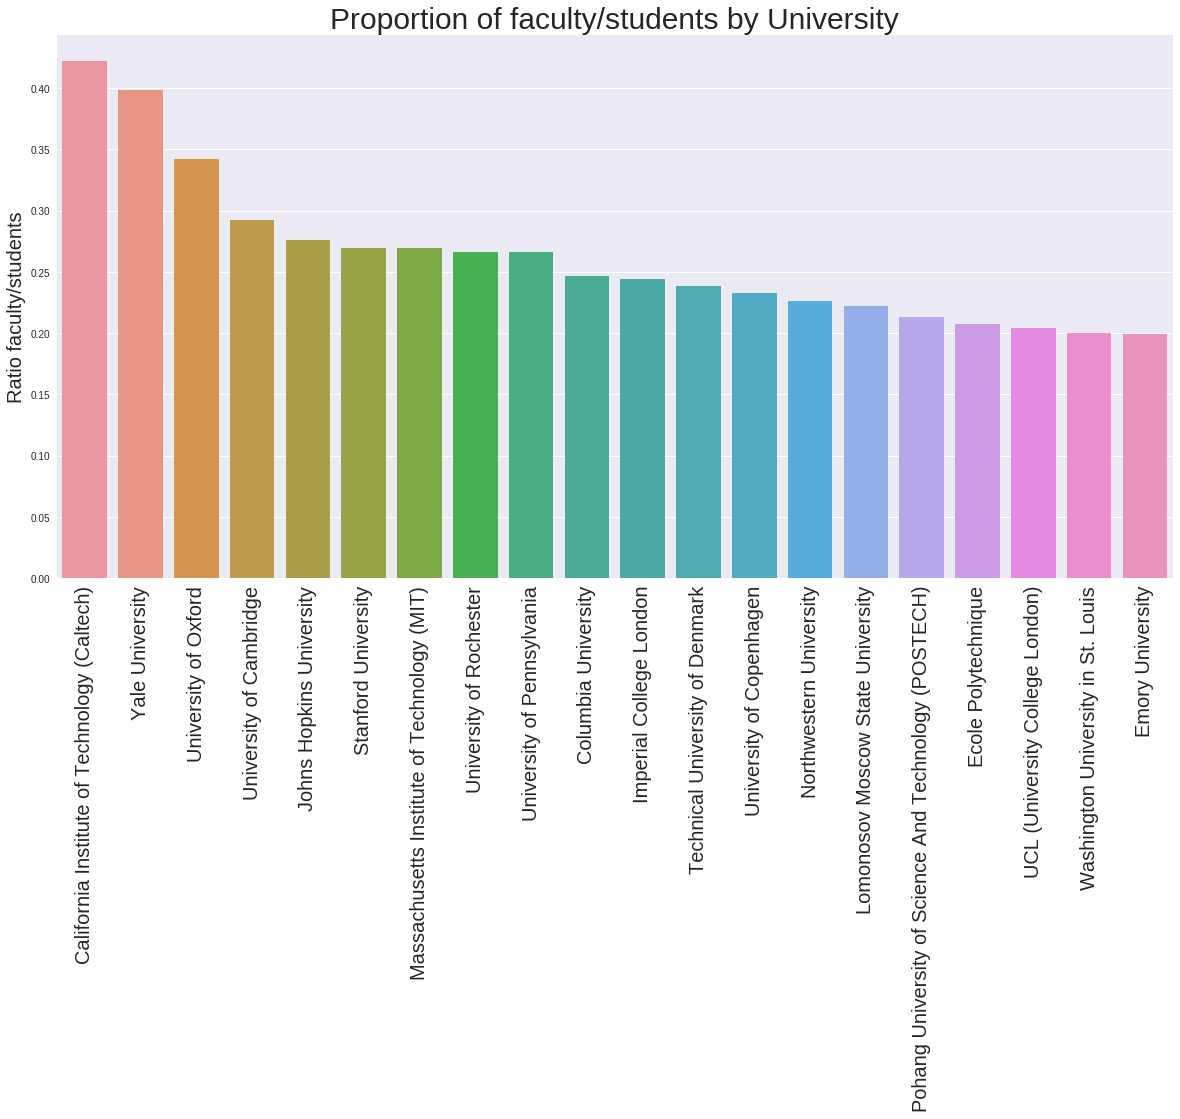

In [14]:
plot_ratio(QS_ratio_university, 'faculty/students', 'faculty/students by University')

### Best international ratio
According to our plot below the university with the highest ratio of international students is LSE.

In [15]:
QS_ratio_university = QS_ratio_university.sort_values(('Ratio', 'international/total'), ascending=False)

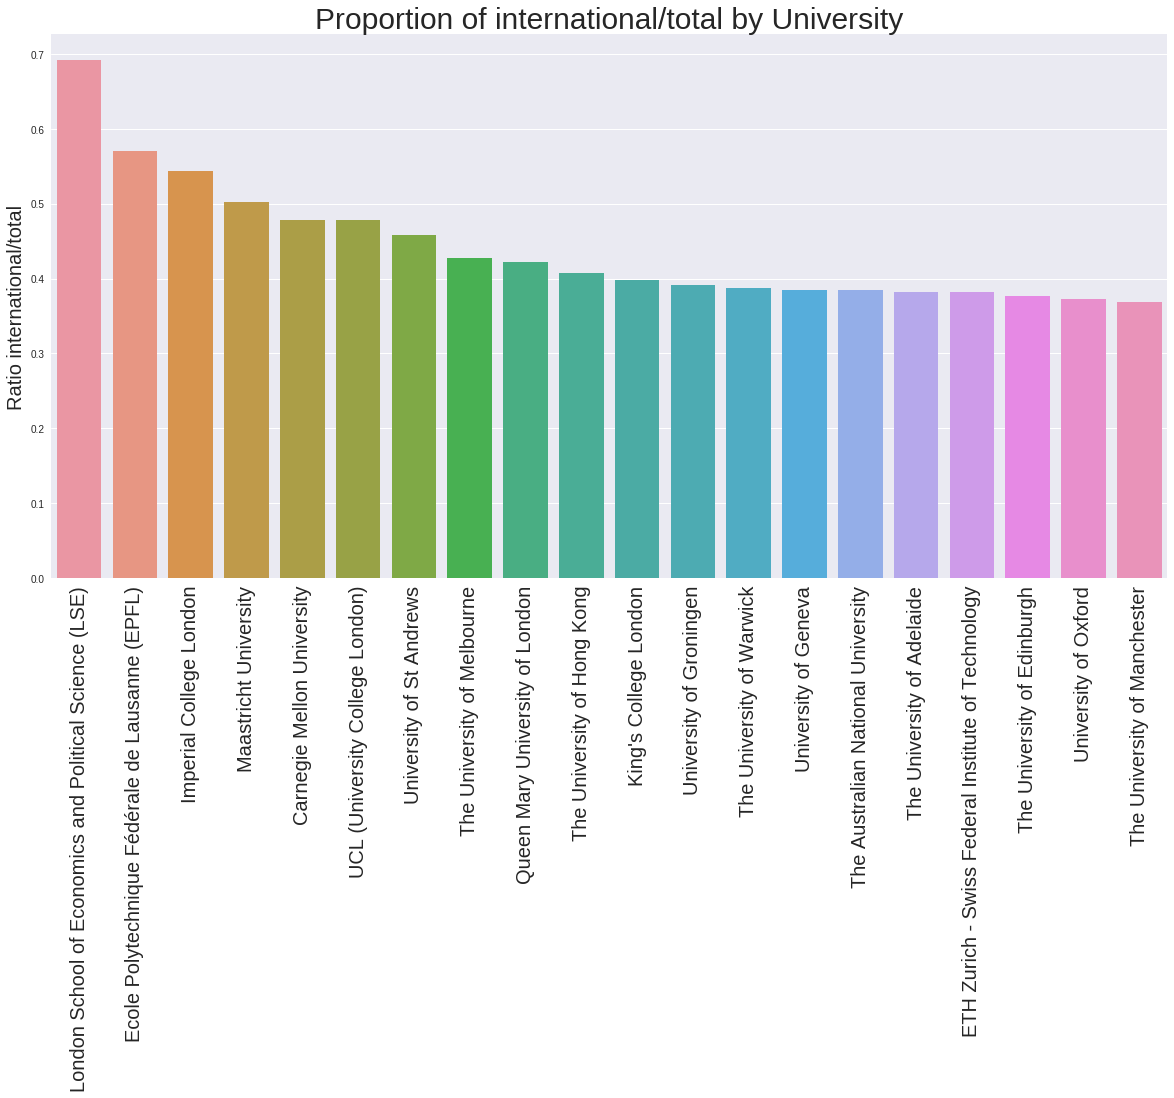

In [16]:
plot_ratio(QS_ratio_university, 'international/total', 'international/total by University')

## Country
We then answer to the same question, aggregating our data in term of country. 

In [17]:
QS_ratio_country = df_rank_QS.copy()
QS_ratio_country = QS_ratio_country.groupby([('', 'Country')]).sum()[['Faculty members', 'Students']]
QS_ratio_country.index.name = 'Country'

QS_ratio_country['Ratio', 'faculty/students'] = QS_ratio_country['Faculty members', 'total']/QS_ratio_country['Students', 'total']
QS_ratio_country['Ratio', 'international/total'] = QS_ratio_country['Students', 'international']/QS_ratio_country['Students', 'total']

### Best faculty/student ratio
Here we can see that Russia has the highest proportion of faculty member / student ratio.

In [18]:
QS_ratio_country = QS_ratio_country.sort_values(('Ratio', 'faculty/students'), ascending=False)

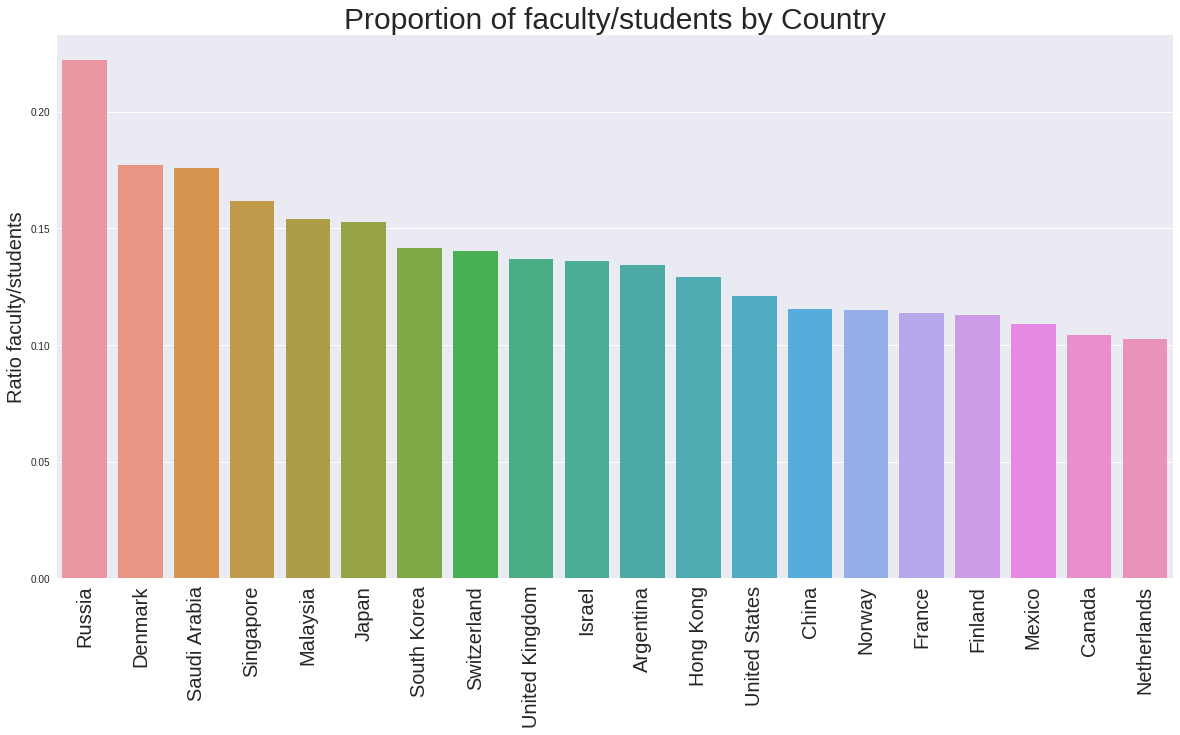

In [19]:
plot_ratio(QS_ratio_country, 'faculty/students', 'faculty/students by Country')

### Best international ratio
Here Australia has the highest proportion of international people.

In [20]:
QS_ratio_country = QS_ratio_country.sort_values(('Ratio', 'international/total'), ascending=False)

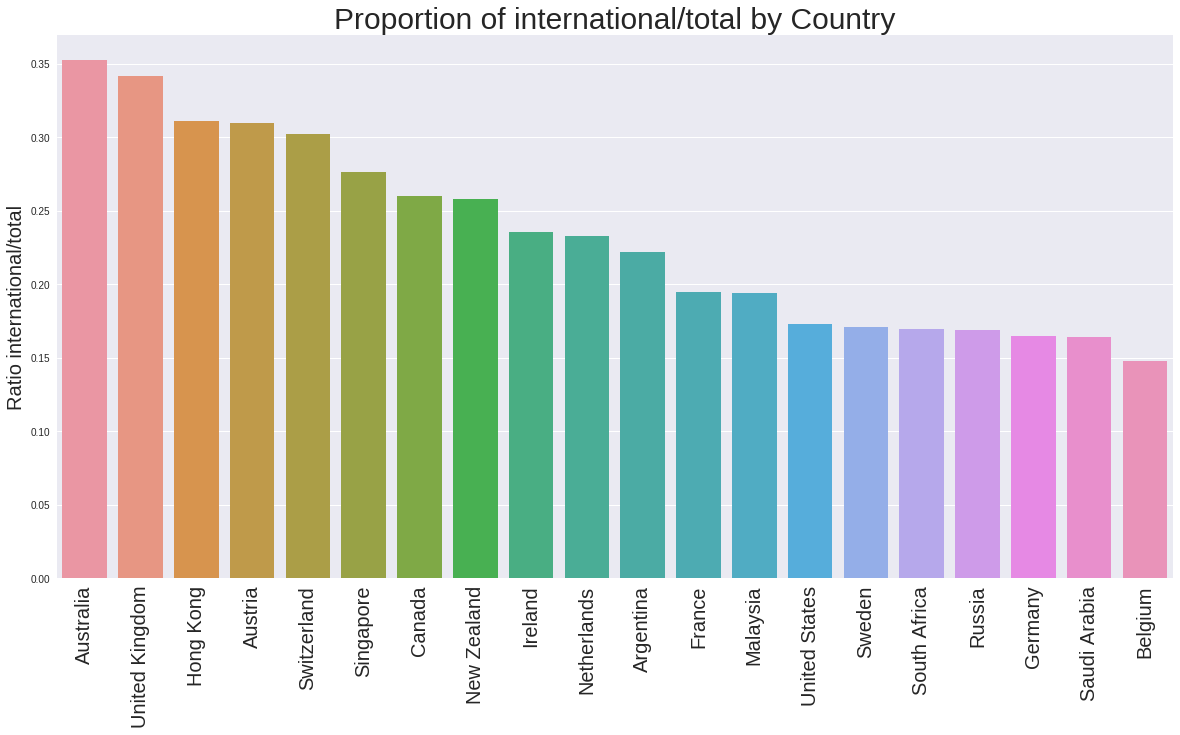

In [21]:
plot_ratio(QS_ratio_country, 'international/total', 'international/total by Country')

## Region
This time Asia seems to be the region with the highest ratio of faculty members/students

In [22]:
QS_ratio_region = df_rank_QS.copy()
QS_ratio_region = QS_ratio_region.groupby([('', 'Region')]).sum()[['Faculty members', 'Students']]
QS_ratio_region.index.name = 'Region'

QS_ratio_region['Ratio', 'faculty/students'] = QS_ratio_region['Faculty members', 'total']/QS_ratio_region['Students', 'total']
QS_ratio_region['Ratio', 'international/total'] = QS_ratio_region['Students', 'international']/QS_ratio_region['Students', 'total']

### Best faculty/student ratio

In [23]:
QS_ratio_region = QS_ratio_region.sort_values(('Ratio', 'faculty/students'), ascending=False)

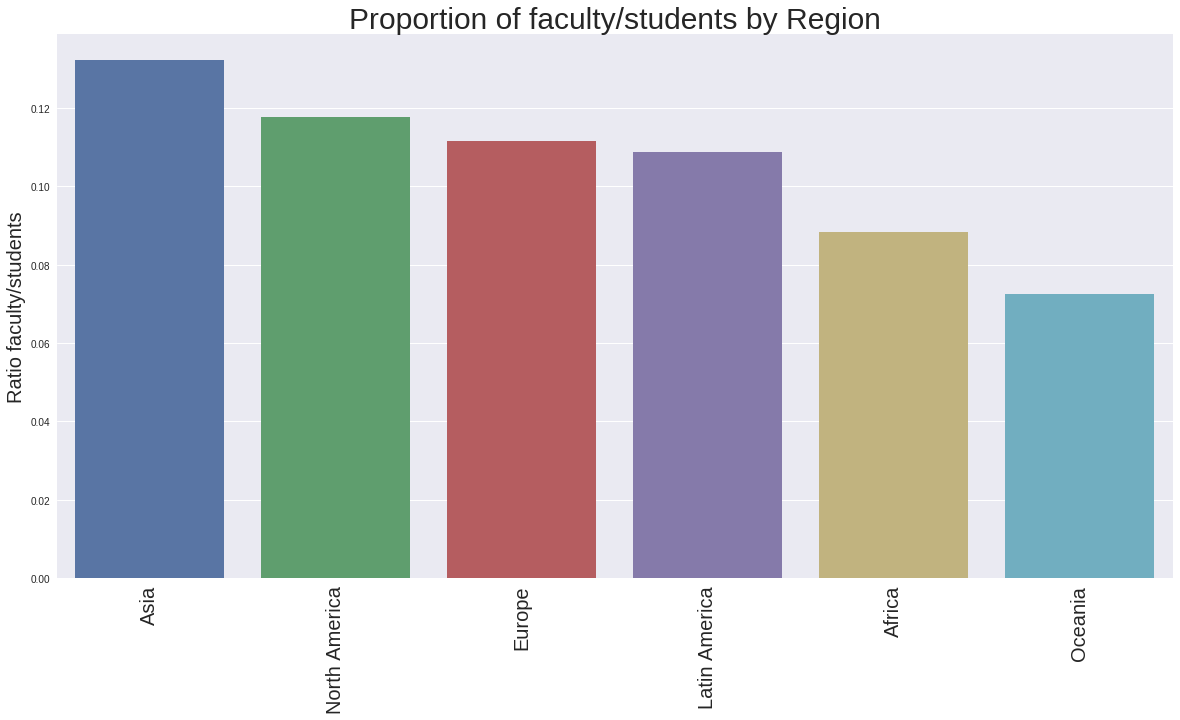

In [24]:
plot_ratio(QS_ratio_region, 'faculty/students', 'faculty/students by Region')

### Best international ratio
Not really surprising, according to the previous result, Oceania has the highest proportion of international people.

In [25]:
QS_ratio_region = QS_ratio_region.sort_values(('Ratio', 'international/total'), ascending=False)

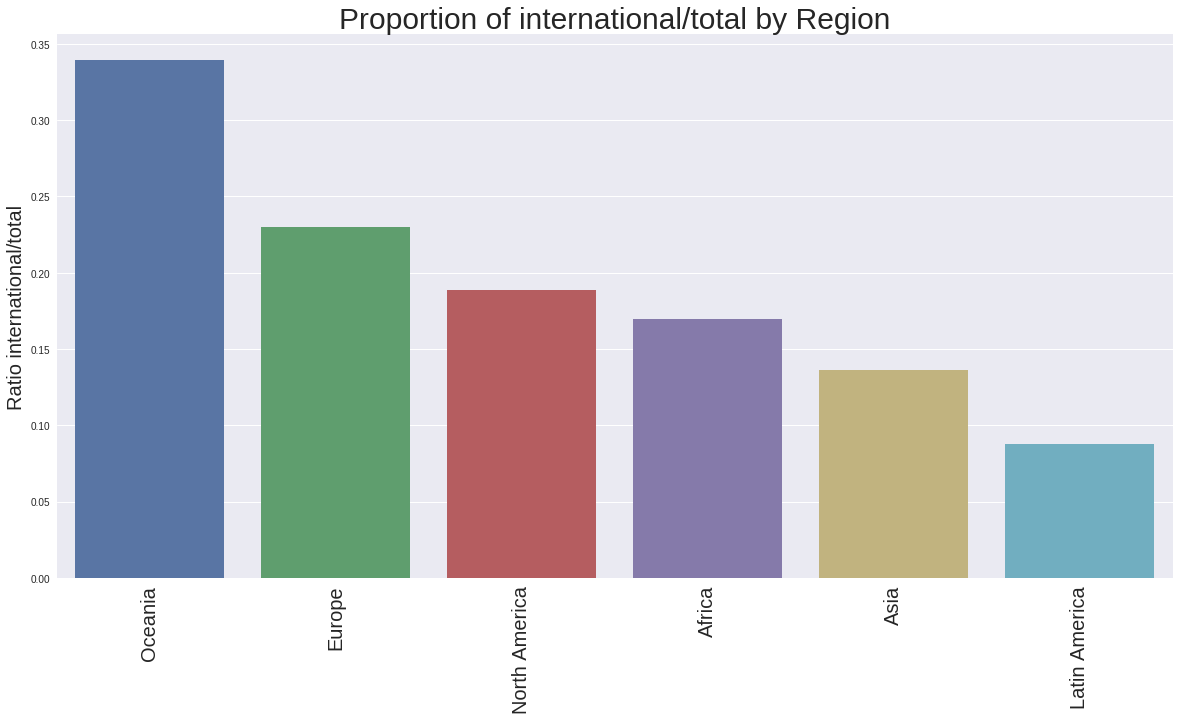

In [26]:
plot_ratio(QS_ratio_region, 'international/total', 'international/total by Region')

# Question 2
Here we will obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018] and repeat the previous analysis.

In [27]:
df_rank_THE['stats_number_students'] = df_rank_THE['stats_number_students'].replace(',', '', regex=True)
df_rank_THE['stats_pc_intl_students'] = df_rank_THE.stats_pc_intl_students.apply(lambda x: float(x.replace('%', ''))/100)
df_rank_THE['stats_student_staff_ratio'] = df_rank_THE.stats_student_staff_ratio.apply(lambda x: 1/float(x))

In [28]:
col = [('', 'Country'),('', 'Rank'), ('Students', 'total'), ('Ratio', 'international/total'), ('Ratio', 'faculty/students')]

df_rank_THE.columns = pd.MultiIndex.from_tuples(col)

df_rank_THE['Students', 'international'] = df_rank_THE[('Students', 'total')].astype(int) * df_rank_THE[('Ratio', 'international/total')].astype(float)
df_rank_THE['Faculty', 'total'] = df_rank_THE[('Ratio', 'faculty/students')].astype(float) * df_rank_THE[('Students', 'total')].astype(int)

df_rank_THE['Faculty', 'total'] = df_rank_THE['Faculty', 'total'].astype(int)
df_rank_THE['Students', 'total'] = df_rank_THE['Students', 'total'].astype(int)


#### We add the region column to the df_rank_THE dataframe with the help of a dictionary created from df_rank_QS

In [29]:
region = dict()

for ind in range(0, len(df_rank_QS)):
    region[df_rank_QS['', 'Country'].iloc[ind]] = df_rank_QS['','Region'].iloc[ind]

region['Luxembourg'] = 'Europe'

In [30]:
# Changing some Country name to match better both websites
df_rank_THE['', 'Country'].replace('Russian Federation', 'Russia', inplace=True)

region_THE = [region[x] if x in region.keys() else None for x in df_rank_THE['', 'Country']]
df_rank_THE['', 'Region'] = region_THE


df_rank_THE = df_rank_THE[[('', 'Country'), ('', 'Region'), ('', 'Rank'), ('Faculty', 'total'), ('Students', 'international'), ('Students', 'total'), ('Ratio', 'faculty/students'), ('Ratio', 'international/total')]]

In [31]:
THE_ratio_university = df_rank_THE.copy()

## University
The university with the highest ratio faculty memeber/student is Vanderbilt university

### Best faculty/student ratio

In [32]:
THE_ratio_university = THE_ratio_university.sort_values(('Ratio', 'faculty/students'), ascending=False)

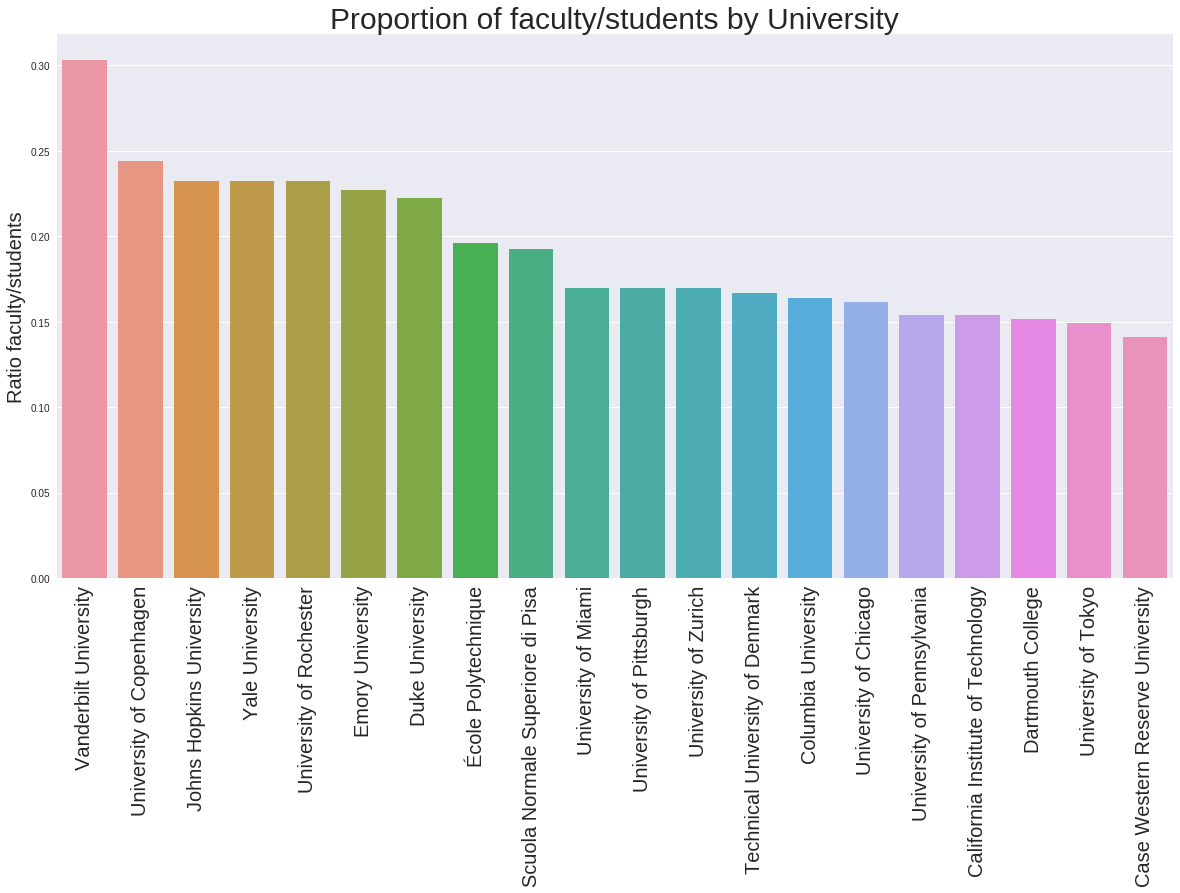

In [33]:
plot_ratio(THE_ratio_university, 'faculty/students', 'faculty/students by University')

### Best international ratio
Here again the highest proportion of international people is at LSE

In [34]:
THE_ratio_university = THE_ratio_university.sort_values(('Ratio', 'international/total'), ascending=False)

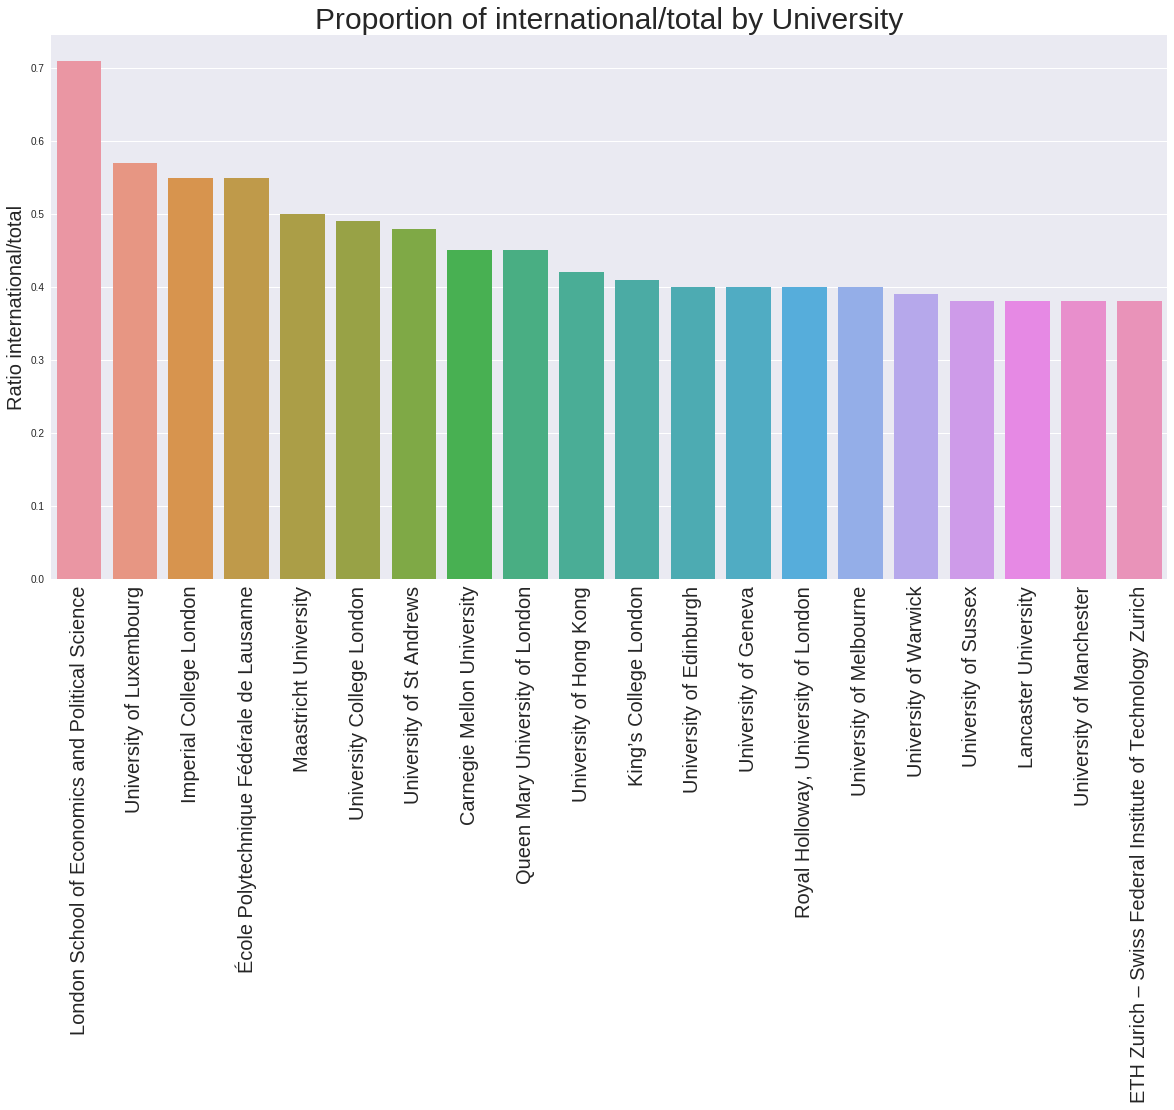

In [35]:
plot_ratio(THE_ratio_university, 'international/total', 'international/total by University')

## Country

In [36]:
THE_ratio_country = df_rank_THE.copy()
THE_ratio_country = THE_ratio_country.groupby([('', 'Country')]).sum()[['Faculty', 'Students']]
THE_ratio_country.index.name = 'Country'

THE_ratio_country['Ratio', 'faculty/students'] = THE_ratio_country['Faculty', 'total']/THE_ratio_country['Students', 'total']
THE_ratio_country['Ratio', 'international/total'] = THE_ratio_country['Students', 'international']/THE_ratio_country['Students', 'total']

### Best faculty/student ratio
This time by country, we can see that Danemark is in first position

In [37]:
THE_ratio_country = THE_ratio_country.sort_values(('Ratio', 'faculty/students'), ascending=False)

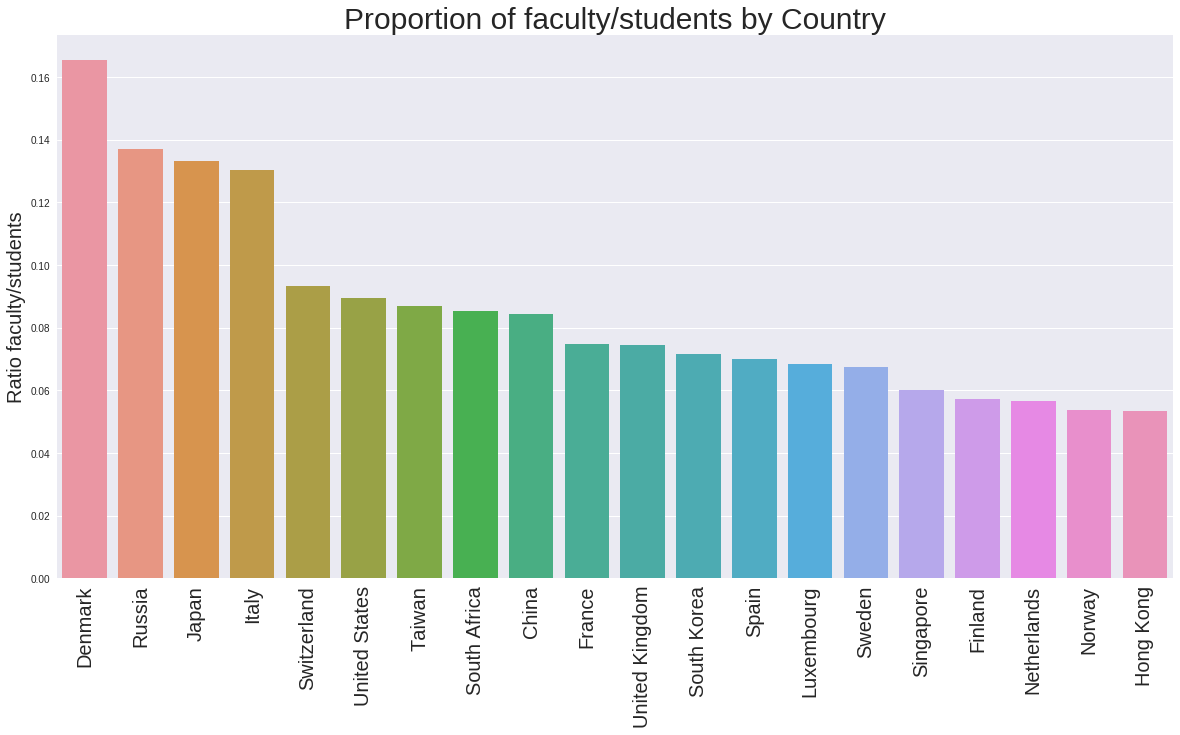

In [38]:
plot_ratio(THE_ratio_country, 'faculty/students', 'faculty/students by Country')

### Best international ratio
We can see below, that Luxembourg has the highest proportion of international people.

In [39]:
THE_ratio_country = THE_ratio_country.sort_values(('Ratio', 'international/total'), ascending=False)

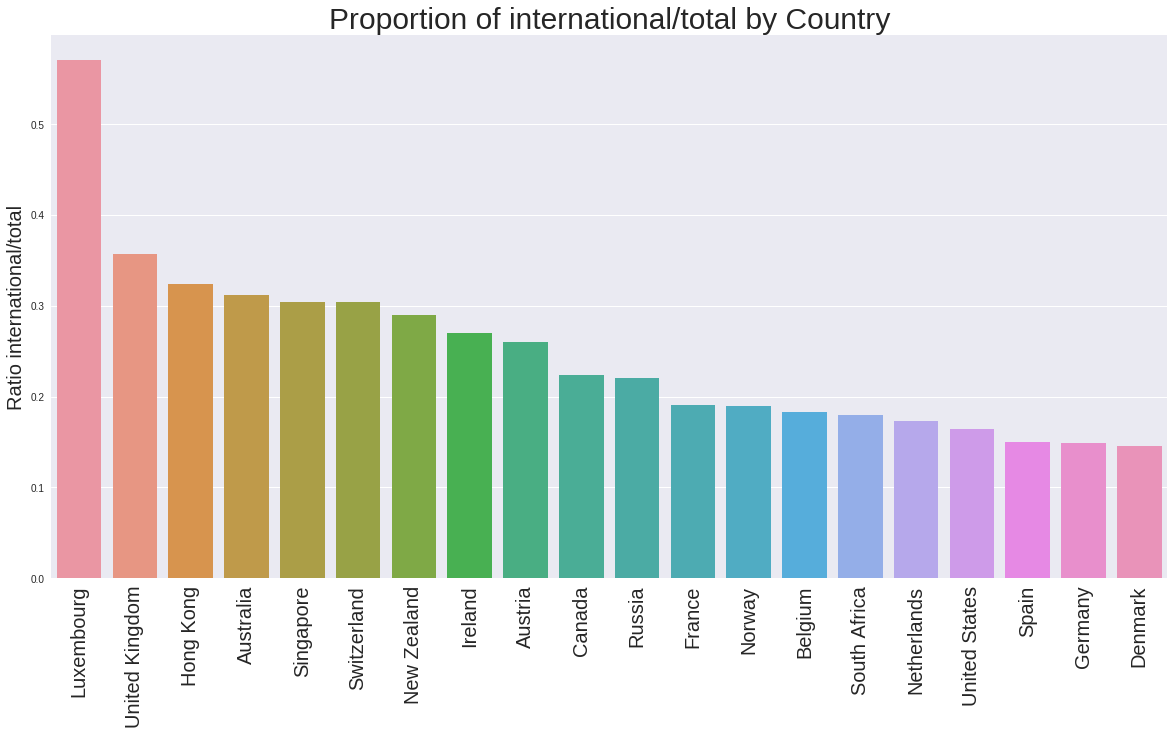

In [40]:
plot_ratio(THE_ratio_country, 'international/total', 'international/total by Country')

In [41]:
THE_ratio_region = df_rank_THE.copy()
THE_ratio_region = THE_ratio_region.groupby([('', 'Region')]).sum()[['Faculty', 'Students']]
THE_ratio_region.index.name = 'Country'

THE_ratio_region['Ratio', 'faculty/students'] = THE_ratio_region['Faculty', 'total']/THE_ratio_region['Students', 'total']
THE_ratio_region['Ratio', 'international/total'] = THE_ratio_region['Students', 'international']/THE_ratio_region['Students', 'total']

### Best faculty/student ratio
Africa this time but not by far is first in term of ratio, faculty members and students

In [42]:
THE_ratio_region = THE_ratio_region.sort_values(('Ratio', 'faculty/students'), ascending=False)

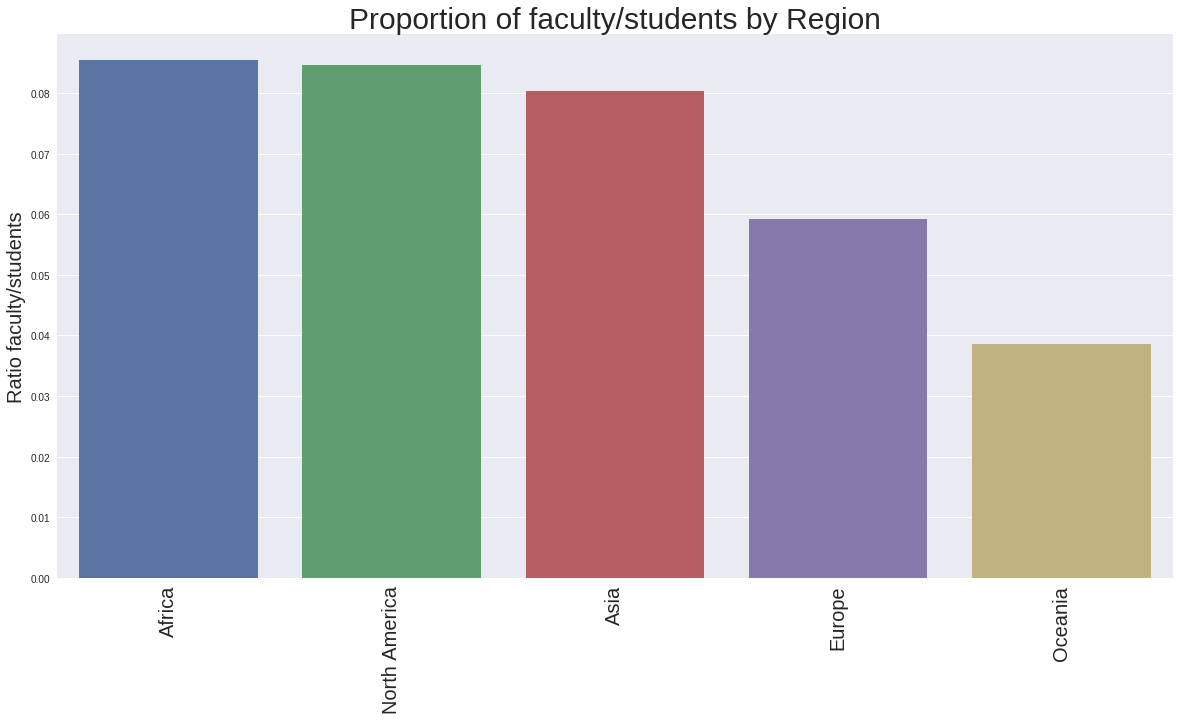

In [43]:
plot_ratio(THE_ratio_region, 'faculty/students', 'faculty/students by Region')

### Best international ratio
Again we can see that Oceania has the highest proportion for this ratio

In [44]:
THE_ratio_region = THE_ratio_region.sort_values(('Ratio', 'international/total'), ascending=False)

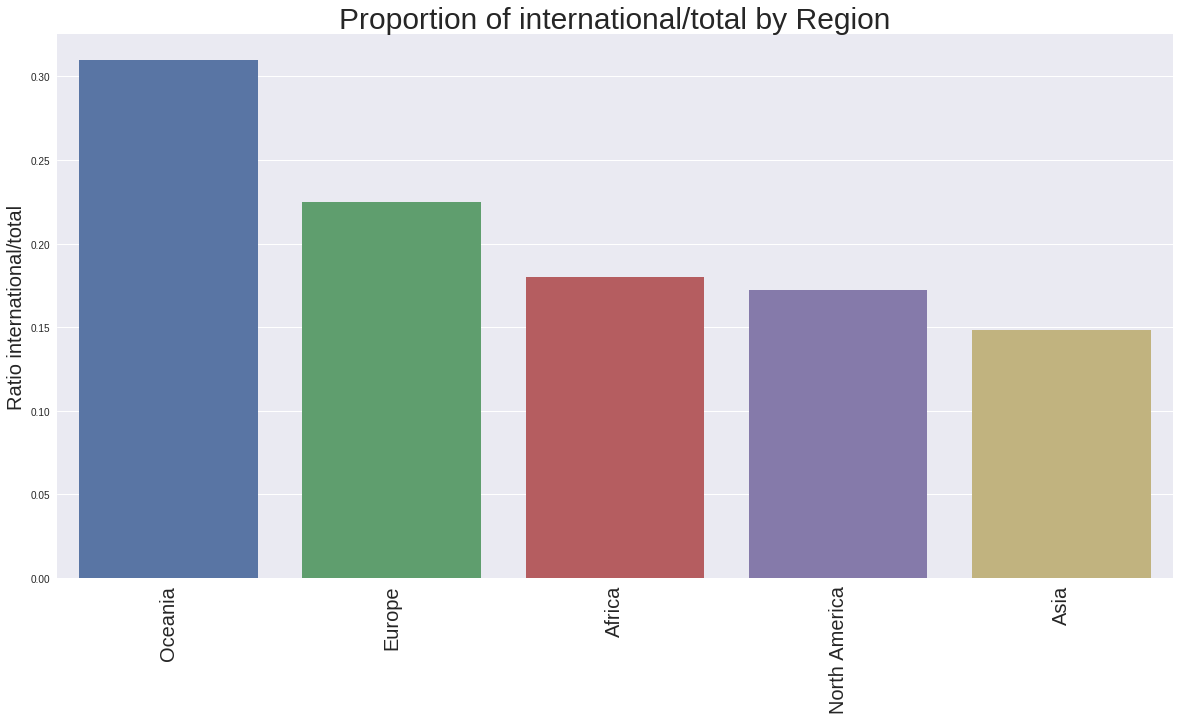

In [45]:
plot_ratio(THE_ratio_region, 'international/total', 'international/total by Region')

### Best international ratio

# Question 3 
Here, we will merge the two DataFrames created in questions 1 and 2 using university names.

In order to match the names of the univerities, we first need to do some preprocessing on the data. Just below, we can see that it can be useful to match the translation of some words as "university" as some of them are not written in english.

In [46]:
translate = {"Autònoma": "Autonomous",
             "Université": "University",
            "Universitat": "University",
            "Universität": "University",
            "Technische": "Technical"}

#Name_sim is the preprocessed name used further to compute the similarity
df_THE_merge = df_rank_THE.sort_values(by=("", "Rank"))[[("", "Rank")]].reset_index().copy()
df_THE_merge.columns = ["name", "rank"]
df_THE_merge["name_sim"] = df_THE_merge["name"].replace({"name_sim":translate}, regex=True)
df_QS_merge = df_rank_QS.sort_values(by=("", "Rank"))[[("", "Rank")]].reset_index().copy()
df_QS_merge.columns = ["name", "rank"]
df_QS_merge["name_sim"] = df_QS_merge["name"].replace({"name_sim":translate}, regex=True)
#df_QS_merge

In order to compute the similarity between the names, we use the sklearn library that will help us to compute Tfidf of each word and thus transform the university names into vectors. We can then compute the cosine similarities between each of them.

In [47]:
corpus = df_THE_merge.name_sim.tolist() + df_QS_merge.name_sim.tolist()
vectorizer = TfidfVectorizer(min_df=1, lowercase=True, strip_accents="unicode", stop_words="english")
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [48]:
#tmpkey is a temporary column used for the merge in order to do a cross computation between names
df_THE_merge['_tmpkey'] = 1
df_QS_merge['_tmpkey'] = 1
df_merge = pd.merge(df_QS_merge[["_tmpkey","name", "name_sim"]], df_THE_merge[["_tmpkey","name", "name_sim"]], on='_tmpkey').drop('_tmpkey', axis=1)
df_merge["cosine_dist"] = df_merge.apply(lambda row: cosine_similarity(vectorizer.transform([row["name_sim_x"], row["name_sim_y"]]))[0,1], axis=1)
df_THE_merge = df_THE_merge.drop('_tmpkey', axis=1)
df_QS_merge = df_QS_merge.drop('_tmpkey', axis=1)

In [49]:
#The cosine_dist refers to the cosine similarities
idx = df_merge.groupby("name_x")["cosine_dist"].idxmax()
df_merge_group = df_merge.loc[idx].sort_values(by ="cosine_dist", ascending=False)
corespondance_table = df_merge_group[(df_merge_group["cosine_dist"]<2) & (df_merge_group["cosine_dist"]>0.4)]
corespondance_table.index = corespondance_table.name_x

#We find a miss match for:
#    Vrije Universiteit Brussel (VUB) 
#    Tokyo Institute of Technology
#    University College Dublin -> Trinity College Dublin appearing twice
#    Ecole normale supérieure, Paris 
#And decided to drop them
to_drop = ["Vrije Universiteit Brussel (VUB)", "Tokyo Institute of Technology", "University College Dublin", "Ecole normale supérieure, Paris"]
corespondance_table = corespondance_table.drop(to_drop)

df = df_rank_QS.loc[corespondance_table.index.values]
df.index = df.index.map(lambda x : corespondance_table.loc[x]["name_y"])
final_df = df.join(df_rank_THE, how = 'left', lsuffix="_THE", rsuffix="_QS")
final_df.head(10)

_THE                      \
                                           Country         Region Rank   
University                                                               
Aalto University                           Finland         Europe  137   
Aarhus University                          Denmark         Europe  119   
Australian National University           Australia        Oceania   20   
Autonomous University of Barcelona           Spain         Europe  156   
Boston University                    United States  North America   81   
Brown University                     United States  North America   53   
California Institute of Technology   United States  North America    4   
Cardiff University                  United Kingdom         Europe  137   
Carnegie Mellon University           United States  North America   47   
Chinese University of Hong Kong          Hong Kong           Asia   46   

                                   Faculty members          Students_THE  \
                                     international   total international   
University                                                                 
Aalto University                             370.0  1257.0        1831.0   
Aarhus University                            602.0  2316.0        3762.0   
Australian National University               927.0  1600.0        5551.0   
Autonomous University of Barcelona           108.0  3863.0        6134.0   
Boston University                            379.0  3157.0        7041.0   
Brown University                             379.0  1303.0        1825.0   
California Institute of Technology           350.0   953.0         647.0   
Cardiff University                           705.0  2755.0        6090.0   
Carnegie Mellon University                   425.0  1342.0        6385.0   
Chinese University of Hong Kong             1074.0  2208.0        4824.0   

                                                        _QS                 \
                                      total         Country         Region   
University                                                                   
Aalto University                    12147.0         Finland         Europe   
Aarhus University                   26226.0         Denmark         Europe   
Australian National University      14442.0       Australia        Oceania   
Autonomous University of Barcelona  46002.0           Spain         Europe   
Boston University                   25662.0   United States  North America   
Brown University                     9251.0   United States  North America   
California Institute of Technology   2255.0   United States  North America   
Cardiff University                  24565.0  United Kingdom         Europe   
Carnegie Mellon University          13356.0   United States  North America   
Chinese University of Hong Kong     18037.0       Hong Kong           Asia   

                                        Faculty   Students_QS         \
                                   Rank   total international  total   
University                                                             
Aalto University                    190     630       2548.80  12744   
Aarhus University                   109    1759       3020.04  25167   
Australian National University       48     828       5595.10  15986   
Autonomous University of Barcelona  147    2504       5169.44  32309   
Boston University                    70    2887       6208.25  24833   
Brown University                     50     831       1779.60   8898   
California Institute of Technology    3     339        596.43   2209   
Cardiff University                  162    1791       6288.36  24186   
Carnegie Mellon University           24     938       5704.20  12676   
Chinese University of Hong Kong      58    1044       5602.32  18072   

                                              Ratio                      
                                   faculty/students international/to

# Question 4

Here we diplay a correlation matrix under the form of a heatmap, and can easily see which feature is or is not correlated with the other. For example here the correlation between the rank and the number of international faculty members = -0.52 which is significant.

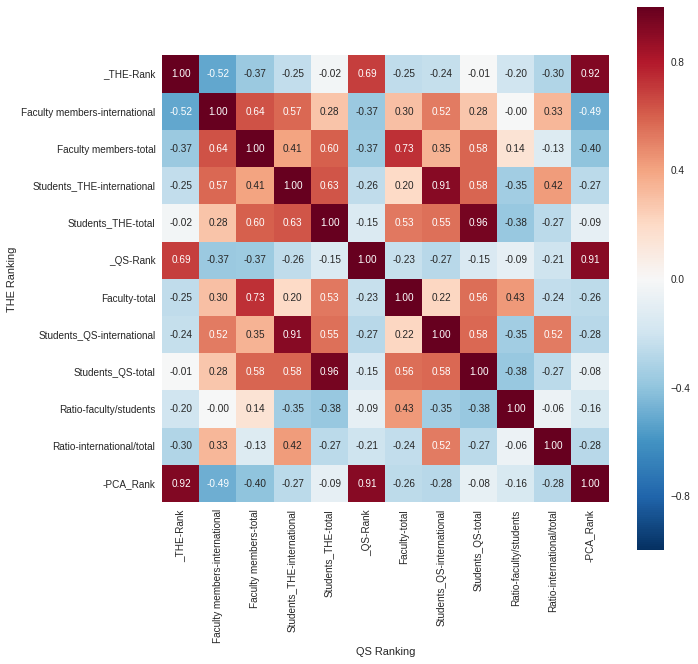

In [54]:
fig, axe = plt.subplots(figsize=(10, 10))
sns.heatmap(final_df.corr(), annot=True, fmt=".2f", square=True)
plt.ylabel('THE Ranking')
plt.xlabel('QS Ranking')
plt.show()

Just below, we represent in a bar plot the number of universities by country, belonging to the top 200 from both ranking sites. 

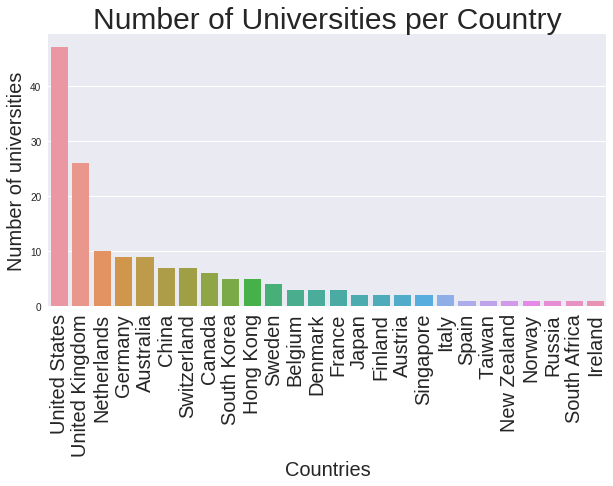

In [51]:
fig, axe = plt.subplots(figsize=(10, 5))
plt.title('Number of Universities per Country', fontsize=30)
plt.xticks(rotation=90, fontsize=20 )
groupby = final_df.groupby([("_THE", "Country")]).size().sort_values(ascending=False)
sns.barplot( x=groupby.index, y=groupby.values)
axe.set_ylabel('Number of universities', fontsize=20)
axe.set_xlabel('Countries', fontsize=20)
plt.show()

# Question 5
To find the best university in the two ranking we are going to perfore PCA (Principal Component Analysis) And sort the university based on principal component.

The scatter plot represent in blue the data before PCA and in red the same data projected onto the principale component.

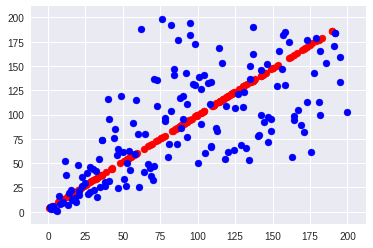

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
final_df[[("_THE", "Rank"), ("_QS", "Rank")]].sort_values(by=("_QS", "Rank"))
points = np.array([final_df[("_THE", "Rank")].values, final_df[("_QS", "Rank")].values])
new_based_point = pca.fit_transform(points.T)
final_df[("", "PCA_Rank")] = new_based_point[:, 0]
final_df = final_df.sort_values(by=("", "PCA_Rank"))
projection = new_based_point.copy() 
projection[:,1] = 0  #Make the projection onto the x axis
pca_in_norm_base = np.linalg.inv(pca.components_).dot(projection.T) + np.mean(points)
#plt.scatter(new_based_point[:, 0], new_based_point[:, 1])
#plt.scatter(projection[:, 0], projection[:, 1])
plt.scatter(pca_in_norm_base[0], pca_in_norm_base[1], color="red")
plt.scatter(points[0], points[1], color="blue")
plt.show()

The first univerity based on our analysis appears to be :

In [53]:
final_df.head(1).index.values[0]

'Stanford University'